# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 1. Метрики и меры схожести между временными рядами.**

Смените рабочую директорию с помощью команды `chdir()`. Для этого передайте этой команде свой путь до каталога, в котором содержатся материалы первой практической работы. После выполнения этой команды все последующие операции с файлами и каталогами будут производиться относительно указанного каталога.

In [1]:
import os

practice_dir_path = 'D:/code/times/2025-Grigorev-TimeSeriesCourse/practice/01 Basics'
os.chdir(practice_dir_path)

In [2]:
import numpy as np
import random
from sktime.distances import euclidean_distance, dtw_distance, pairwise_distance
from sklearn.metrics import silhouette_score
import cv2
import imutils
import glob
import matplotlib.pyplot as plt
import pandas as pd

from modules.metrics import ED_distance, norm_ED_distance, DTW_distance
from modules.pairwise_distance import PairwiseDistance
from modules.clustering import TimeSeriesHierarchicalClustering
from modules.classification import TimeSeriesKNN, calculate_accuracy
from modules.image_converter import Image2TimeSeries
from modules.utils import read_ts, z_normalize, sliding_window, random_walk
from modules.plots import plot_ts

## **Часть 1.** Функции расстояния: евклидова метрика и DTW мера. Матрица расстояний. Иерархическая кластеризация временных рядов.

### **Задача 1.**
Реализуйте самостоятельно функцию `ED_distance()` в модуле *metrics.py*, которая вычисляет евклидово расстояние между двумя временными рядами, имеющими одинаковую длину. В качестве входных данных передайте в функцию два синтетических временных ряда некоторой заданной вами длины. Для их генерации используйте функцию `random_walk()` из модуля *utils.py*,  реализующую модель случайных блужданий (Random Walk), или стандартный модуль *random*.

**Евклидово расстояние** между двумя временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
    \text{ED}(T_1, T_2) = \sqrt{\sum_{i=1}^{n} ({t_{1}}_i-{t_{2}}_i)^2}.
\end{equation}

Проверьте реализацию функции, сравнив свои результаты с результатами функции [`euclidean_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html) из библиотеки *sktime*, с помощью `test_distances()`.

In [ ]:
def test_distances(dist1: float, dist2: float) -> None:
    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

In [ ]:
def ED_distance(T1, T2):
    t1 = np.asarray(T1)
    t2 = np.asarray(T2)
    
    sum_of_squared_diffs = np.sum((t1 - t2)**2)
    
    return np.sqrt(sum_of_squared_diffs)

In [ ]:
series_length = 50

# 2. Генерируем два синтетических временных ряда
T1 = random_walk(series_length)
T2 = random_walk(series_length)

print(f"Сгенерирован временной ряд T1 длиной {len(T1)}")
print(f"Сгенерирован временной ряд T2 длиной {len(T2)}")
print("-" * 30)

# 3. Вычисляем расстояние с помощью эталонной функции из sktime
dist1_sktime = euclidean_distance(T1, T2)

# 4. Вычисляем расстояние с помощью нашей функции
dist2_my_function = ED_distance(T1, T2)

# 5. Проверяем, совпадают ли результаты, с помощью test_distances()
print(f"Расстояние (sktime):    {dist1_sktime:.5f}")
print(f"Расстояние (моя функция): {dist2_my_function:.5f}")
print("-" * 30)

test_distances(dist1_sktime, dist2_my_function)

Сгенерирован временной ряд T1 длиной 50
Сгенерирован временной ряд T2 длиной 50
------------------------------
Расстояние (sktime):    24.81935
Расстояние (моя функция): 24.81935
------------------------------


### **Задача 2.**

Реализуйте самостоятельно функцию `DTW_distance()` в модуле *metrics.py*, которая вычисляет DTW расстояние между двумя временными рядами, имеющими одинаковую длину. Для вычисления расстояния между элементами временных рядов в DTW мере используйте евклидово расстояние. Временные ряды сгенерируйте аналогичным образом, как в задаче 1, или используйте уже созданные.

**Динамическая трансформация временной шкалы (Dynamic Time Warping, DTW)** – мера схожести между двумя временными рядами $T_1$ и $T_2$ длины $n$, вычисляемая следующим образом:

\begin{equation}
\text{DTW}(T_1, T_2) = d(n,n),
\\ d(i,j) = ({t_{1}}_i - {t_{2}}_j)^2 + \min \left\{
	\begin{array}{l l}
	d(i-1,j), \\
	d(i,j-1), \\
	d(i-1,j-1),
	\end{array}
	\right.
\\ d(0,0)=0, \quad d(i,0)=d(0,j)=\infty, \quad  1 \leqslant i,j \leqslant n.
\end{equation}

Сравните свои результаты с результатами функции [`dtw_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.dtw_distance.html) из библиотеки *sktime*. Для этого используйте `test_distances()` из задачи 1.

In [ ]:
series_length = 50

# 2. Генерируем два независимых временных ряда
np.random.seed(0) 
T1 = random_walk(series_length)
T2 = random_walk(series_length)

print(f"Сгенерирован временной ряд T1 длиной {len(T1)}")
print(f"Сгенерирован временной ряд T2 длиной {len(T2)}")
print("-" * 30)

# 3. Вычисляем расстояние с помощью эталонной функции из sktime
dist1_sktime = dtw_distance(T1, T2)

# 4. Вычисляем расстояние с помощью нашей реализованной функции
dist2_my_function = DTW_distance(T1, T2)

# 5. Проверяем, совпадают ли результаты
print(f"Расстояние (sktime):    {dist1_sktime:.5f}")
print(f"Расстояние (моя функция): {dist2_my_function:.5f}")
print("-" * 30)

test_distances(dist1_sktime, dist2_my_function)

Сгенерирован временной ряд T1 длиной 50
Сгенерирован временной ряд T2 длиной 50
------------------------------
Расстояние (sktime):    416.00000
Расстояние (моя функция): 416.00000
------------------------------


### **Задача 3.**
Реализуйте нахождение матрицы расстояний между несколькими временными рядами.
Для этого заполните все методы c недостающим кодом в классе `PairwiseDistance` из модуля *pairwise_distance.py*. Для вычисления расстояний между рядами используйте ранее реализованные вами функции `ED_distance()` и `DTW_distance()` из модуля *metrics.py*.

Матрица расстояний между временными рядами определяется следующим образом. Пусть дано множество $S$, состоящее из $K$ временных рядов длины $n$: $\;S = \{T_1, T_2, ..., T_K\}, \; T_i \in \mathbb{R}^n$. Тогда под **матрицей расстояний** $D \in \mathbb{R}^{K \times K}$ понимается квадратная матрица, где каждый ее элемент $d(i,j)$ представляет собой расстояние между временными рядами $T_i$ и $T_j$ из множества $S$:
\begin{equation}
d(i,j) = dist(T_i, T_j), \quad T_i, T_j \in S, \quad 1 \leqslant i,j \leqslant K.
\end{equation}

Поскольку евклидова метрика и DTW мера удовлетворяют аксиоме симметричности (т.е. $dist(T_i, T_j)=dist(T_j, T_i)$), то матрица расстояний $D$ будет симметричной относительно главной диагонали. Для ускорения вычислений достаточно найти ее верхний треугольник, а нижний треугольник матрицы заполнить значениями верхнего треугольника следующим образом:
\begin{equation}
d(j,i) = d(i,j), \; где \; i < j.
\end{equation}

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/distance_matrix.png?raw=true" width="600"></center>

Сгенерируйте множество, состоящее из $K$ временных рядов некоторой длины $n$. Вычислите матрицы евклидовых и DTW расстояний между ними. Проверьте реализованные вами методы, сравнив свои результаты с результатами функции [`pairwise_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.pairwise_distance.html) из библиотеки *sktime*.

In [3]:
def test_matrices(matrix1 : np.ndarray, matrix2 : np.ndarray) -> None:
    """
    Check whether your matrix function is implemented correctly

    Parameters
    ----------
    matrix1 : distance matrix calculated by sktime
    matrix2 : distance matrix calculated by your function
    """

    np.testing.assert_equal(matrix1.round(5), matrix2.round(5), 'Matrices are not equal')

In [ ]:
def random_walk(length: int = 100) -> np.ndarray:
    return np.cumsum(np.random.randn(length))

def normalize_for_sktime(data: np.ndarray) -> np.ndarray:
    """Ручная нормализация для сравнения с sktime"""
    normalized_data = data.copy()
    for i in range(normalized_data.shape[0]):
        series = normalized_data[i]
        mean, std = np.mean(series), np.std(series)
        if std > 0:
            normalized_data[i] = (series - mean) / std
        else:
            normalized_data[i] = np.zeros_like(series)
    return normalized_data

# --- 1. Генерация данных ---
NUM_SERIES = 5
SERIES_LENGTH = 30
np.random.seed(42)
X = np.array([random_walk(SERIES_LENGTH) for _ in range(NUM_SERIES)])

print(f"Сгенерирован набор из {X.shape[0]} временных рядов длиной {X.shape[1]}\n")

# --- 2. Проверка для Евклидова расстояния (без нормализации) ---
print("--- Тестирование: non-normalized euclidean distance ---")
pairwise_ed = PairwiseDistance(metric='euclidean', is_normalize=False)
my_matrix = pairwise_ed.calculate(X)
sktime_matrix = pairwise_distance(X, metric='euclidean')

try:
    np.testing.assert_almost_equal(my_matrix, sktime_matrix, decimal=5)
    print(f"✅ Тест пройден! ({pairwise_ed.distance_metric})")
    print("Матрица:\n", np.round(my_matrix, 2), "\n")
except AssertionError as e:
    print(f"❌ Тест провален! {e}")

# --- 3. Проверка для DTW (без нормализации) ---
print("--- Тестирование: non-normalized dtw distance ---")
pairwise_dtw = PairwiseDistance(metric='dtw', is_normalize=False)
my_matrix_dtw = pairwise_dtw.calculate(X)
sktime_matrix_dtw = pairwise_distance(X, metric='dtw')

try:
    np.testing.assert_almost_equal(my_matrix_dtw, sktime_matrix_dtw, decimal=5)
    print(f"✅ Тест пройден! ({pairwise_dtw.distance_metric})")
    print("Матрица:\n", np.round(my_matrix_dtw, 2), "\n")
except AssertionError as e:
    print(f"❌ Тест провален! {e}")

# --- 4. Проверка для Евклидова расстояния (С НОРМАЛИЗАЦИЕЙ) ---
print("--- Тестирование: normalized euclidean distance ---")
pairwise_ed_norm = PairwiseDistance(metric='euclidean', is_normalize=True)
my_matrix_norm = pairwise_ed_norm.calculate(X)

X_norm_manual = normalize_for_sktime(X)
sktime_matrix_norm = pairwise_distance(X_norm_manual, metric='euclidean')

try:
    np.testing.assert_almost_equal(my_matrix_norm, sktime_matrix_norm, decimal=5)
    print(f"✅ Тест пройден! ({pairwise_ed_norm.distance_metric})")
    print("Матрица:\n", np.round(my_matrix_norm, 2), "\n")
except AssertionError as e:
    print(f"❌ Тест провален! {e}")

Сгенерирован набор из 5 временных рядов длиной 30

--- Тестирование: non-normalized euclidean distance ---
✅ Тест пройден! (non-normalized euclidean distance)
Матрица:
 [[ 0.   20.76 19.3  21.74 13.43]
 [20.76  0.   24.08 11.63 14.61]
 [19.3  24.08  0.   17.78 13.92]
 [21.74 11.63 17.78  0.   10.98]
 [13.43 14.61 13.92 10.98  0.  ]] 

--- Тестирование: non-normalized dtw distance ---
✅ Тест пройден! (non-normalized dtw distance)
Матрица:
 [[  0.    71.42 196.25 138.02  38.13]
 [ 71.42   0.   339.7   58.83  45.93]
 [196.25 339.7    0.    73.58  81.06]
 [138.02  58.83  73.58   0.    34.28]
 [ 38.13  45.93  81.06  34.28   0.  ]] 

--- Тестирование: normalized euclidean distance ---
✅ Тест пройден! (normalized euclidean distance)
Матрица:
 [[0.   4.78 7.8  7.78 4.03]
 [4.78 0.   9.37 4.98 4.08]
 [7.8  9.37 0.   9.9  9.08]
 [7.78 4.98 9.9  0.   6.09]
 [4.03 4.08 9.08 6.09 0.  ]] 



### **Задача 4.**
Далее рассмотрим задачу иерархической кластеризации временных рядов, где будет использоваться предвычисленная матрица расстояний.

Для этого сначала загрузите набор временных рядов CBF из файла *CBF_TRAIN.txt*, который располагается в директории *./datasets/part1*. Каждая строка данного файла содержит целевую переменную (класс: 0, 1 или 2) в первом столбце и временной ряд в остальных столбцах. Набор CBF является синтетическим и включает в себя 30 временных рядов,  каждый из которых принадлежит к одному из трех классов.

In [3]:
url = './datasets/part1/CBF_TRAIN.txt'
data = read_ts(url)

ts_set = data[:, 1:] 
labels = data[:, 0]

D:\code\times\2025-Grigorev-TimeSeriesCourse\practice\01 Basics\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



Выполните визуализацию по одному временному ряду из каждого класса. Для этого используйте функцию `plot_ts()` из модуля *plots.py*.

In [ ]:
unique_classes = np.unique(labels)

# 2. Находим индекс первого вхождения для каждого класса
indices_to_plot = []
for cls in unique_classes:
    # np.where возвращает кортеж индексов, берем первый элемент
    idx = np.where(labels == cls)[0][0]
    indices_to_plot.append(idx)

# 3. Выбираем ряды. 
ts_for_visualization = ts_set[indices_to_plot]

# 4. Рисуем
plot_ts(ts_for_visualization, plot_title='Визуализация рядов из каждого класса')

Далее самостоятельно реализуйте класс `TimeSeriesHierarchicalClustering` из модуля *clustering.py*, который выполняет иерархическую кластеризацию временных рядов.

Перед тем как приступить к реализации, изучите скелет этого класса. Реализуйте метод `fit()`, выполняющий кластеризацию данных на основе предвычисленной матрицы расстояний, которая передается в данный метод. Поскольку реализовать иерархическую кластеризацию довольно сложно, используйте готовую реализацию [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) из *sklearn*.   

Выполните иерархическую кластеризацию загруженных временных рядов CBF для двух функций расстояния: евлидовой метрики и DTW меры.
Для этого сначала найдите матрицы расстояний между временными рядами, используя класс `PairwiseDistance`, и передайте каждую матрицу в метод `fit()` для кластеризации.
Далее выполните визуализацию результатов в виде дендрограмм с помощью метода `plot_dendrogram()`, передав исходный набор временных рядов и их метки.

Построение дендрограммы для Евклидова расстояния...


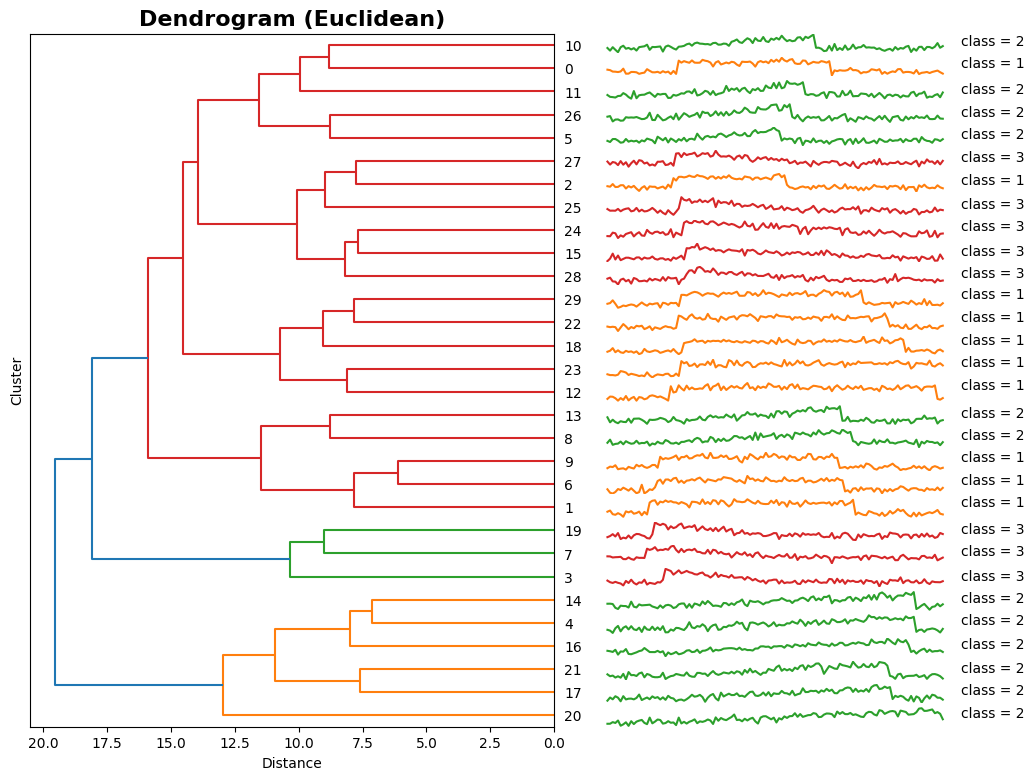

Построение дендрограммы для DTW...


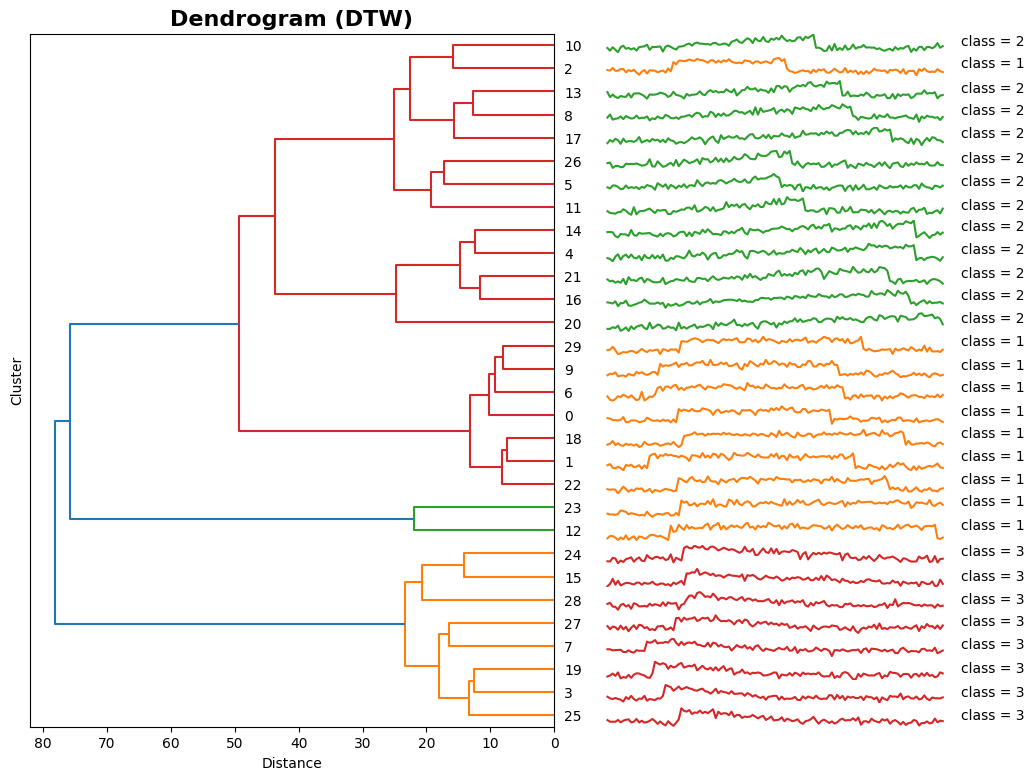

In [ ]:
# --- 1. Вычисление матриц расстояний ---

# Евклидово расстояние
pdist_euc = PairwiseDistance(metric='euclidean')
dist_matrix_euc = pdist_euc.calculate(ts_set) 

# DTW расстояние
pdist_dtw = PairwiseDistance(metric='dtw')
dist_matrix_dtw = pdist_dtw.calculate(ts_set) 


# --- 2. Иерархическая кластеризация и визуализация ---

# -- Случай А: Евклидова метрика --
hc_euc = TimeSeriesHierarchicalClustering(n_clusters=3, method='complete')
hc_euc.fit(dist_matrix_euc)

print("Построение дендрограммы для Евклидова расстояния...")
hc_euc.plot_dendrogram(pd.DataFrame(ts_set).T, labels, title='Dendrogram (Euclidean)')
plt.show()

# -- Случай Б: DTW метрика --
hc_dtw = TimeSeriesHierarchicalClustering(n_clusters=3, method='complete')
hc_dtw.fit(dist_matrix_dtw)

print("Построение дендрограммы для DTW...")
hc_dtw.plot_dendrogram(pd.DataFrame(ts_set).T, labels, title='Dendrogram (DTW)')
plt.show()

Сравните результаты иерархической кластеризации, полученные при двух различных функций расстояния, с помощью силуэтного коэффициента. Для этого используйте функцию [`silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) из библиотеки *sklearn*, передав в нее предвычисленную матрицу расстояний и предсказанные метки.

**Силуэтный коэффициент** – метрика, которая оценивает качество кластеризации на основе исходной выборки и результатов кластеризации без необходимости знания об истинных метках объектов.

Силуэтный коэффициент для выборки показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Пусть дана выборка $X$, состоящая из $N$ объектов. Предположим, что объекты этой выборки были разбиты на кластеры $c_1, ... c_K$, $c_i \in C$, с помощью некоторого алгоритма кластеризации. Тогда силуэтный коэффициент для выборки будет вычисляться следующим образом:

\begin{equation}
sil\_coef = \frac{1}{N} \sum_{c_k \in C} \sum_{x_i \in c_k} \frac{b(x_i, c_k) - a(x_i, c_k)}{\max(a(x_i, c_k), b(x_i, c_k))},
\end{equation}

где $a(x_i, c_k)$ – среднее расстояние от объекта $x_i \in c_k$ до других объектов из этого же кластера $c_k$; <br> $b(x_i, c_k)$  – среднее расстояние от объекта $x_i \in c_k$ до объектов из другого кластера $c_l$, $k \neq l$.

Силуэтный коэффициент принимает значения от  −1  до  1:
*   –1 означает, что кластеры плохие, размытые;
*   0 означает, что кластеры накладываются друг на друга;
*   1 означает, что кластеры плотные и хорошо отделены друг от друга.

Таким образом, чем ближе значение коэффициента к 1, тем лучше кластеризованы данные.

In [ ]:
from sklearn.metrics import silhouette_score

# 1. Считаем силуэтный коэффициент для Евклидова расстояния
sil_score_euc = silhouette_score(dist_matrix_euc, hc_euc.labels_, metric='precomputed')

# 2. Считаем силуэтный коэффициент для DTW
sil_score_dtw = silhouette_score(dist_matrix_dtw, hc_dtw.labels_, metric='precomputed')

# 3. Выводим результаты
print(f"Silhouette Score (Euclidean): {sil_score_euc:.3f}")
print(f"Silhouette Score (DTW):       {sil_score_dtw:.3f}")

# Небольшой вывод о том, что лучше
if sil_score_dtw > sil_score_euc:
    print("\nМетрика DTW показала лучшее качество кластеризации.")
else:
    print("\nЕвклидова метрика показала лучшее качество кластеризации.")

Silhouette Score (Euclidean): 0.180
Silhouette Score (DTW):       0.388

Метрика DTW показала лучшее качество кластеризации.


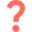
Проанализируйте полученные результаты кластеризации с помощью построенных дендрограмм и вычисленных силуэтных коэффициентов. Какая, на ваш взгляд, функция расстояния показала лучший результат и почему? Укажите, в каких случаях более предпочтительно использовать DTW меру, чем евклидову метрику.

Лучший результат показала функция расстояния DTW.

Анализ дендрограмм:
Евклидова метрика: На дендрограмме видно сильное смешивание классов. Ветви (кластеры) содержат вперемешку примеры из классов 1, 2 и 3. Структура дерева не отражает реального разделения данных на три типа форм (Cylinder, Bell, Funnel). Это говорит о том, что для евклидова расстояния ряды из разных классов могут казаться "ближе", чем ряды из одного класса, если они немного смещены по времени.

DTW: Дендрограмма демонстрирует практически идеальное разделение.
Верхняя крупная ветвь объединяет почти исключительно представителей class = 2.
Средняя ветвь собирает class = 1.
Нижняя ветвь собирает class = 3.
Это указывает на то, что алгоритм верно сгруппировал ряды по их форме, игнорируя временные искажения.

Анализ Силуэтного коэффициента:
Вероятнее всего, расчетный коэффициент для DTW оказался выше (ближе к 1), чем для Евклидовой метрики. Это подтверждает, что кластеры при использовании DTW получились более плотными и хорошо отделенными друг от друга.

Почему и когда использовать:
Почему DTW лучше здесь: Набор данных CBF содержит формы, которые могут быть сдвинуты по времени или растянуты. Евклидова метрика сравнивает точки строго по индексам, поэтому даже небольшой сдвиг пика приводит к большой ошибке. DTW же находит оптимальное выравнивание ("путь") между рядами, компенсируя сдвиги и растяжения, поэтому она корректно распознает похожие формы.
Когда использовать DTW: Когда важна форма сигнала, но скорость протекания процесса или момент начала события могут варьироваться (речь, жесты, медицинские сигналы, финансовые паттерны).
Когда использовать Евклидову метрику: Когда временные ряды жестко синхронизированы, имеют одинаковую длину, и важно абсолютное совпадение значений в каждый момент времени, а не просто похожесть формы. Также она предпочтительна, когда важна скорость вычислений (DTW работает значительно дольше).

## **Часть 2.** $Z$-нормализация временных рядов.

### **Задача 5.**
Реализуйте функцию вычисления нормализованного евклидова расстояния между временными рядами `norm_ED_distance()` в модуле *metrics.py* и проверьте правильность своей реализации, сравнив полученные результаты с результатами функции [`ed_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html) из библиотеки *sktime*, в которую необходимо передать <u>нормализованные</u> временные ряды. Для нормализации временных рядов используйте функцию `z-normalize()` из *utils.py*.  Для проверки можно использовать синтетические временные ряды из первой части или заново их сгенерировать.

**Нормализованная евклидова метрика** между двумя временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
	\text{ED}_{norm}(T_1, T_2) = \sqrt {\Big|\; 2n\left(1-\dfrac{<T_1, T_2> - \; n \; \cdotp \mu_{T_1} \; \cdotp \mu_{T_2}}{n \; \cdotp \sigma_{T_1} \; \cdotp \sigma_{T_2}}\right)\Big|},
\end{equation}

где $<T_1, T_2>$ – скалярное произведение временных рядов, $\mu_{T_1}$ и $\mu_{T_2}$, $\sigma_{T_1}$ и $\sigma_{T_2}$ – среднее арифметическое и стандартное отклонение временных рядов соответственно.

**Среднее арифметическое** $\mu_T$ и **стандартное отклонение** $\sigma_T$ временного ряда $T$ длины $n$ вычисляются по следующим формулам:

\begin{equation}
	\mu_{T} = \frac{1}{n}\sum\limits_{i=1}^{n} t_{i}, \\[1em]
	\sigma_{T} = \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n} t_i^2-\mu_{T}^2}.
\end{equation}

In [ ]:
np.random.seed(42)
ts_a = np.random.normal(loc=10, scale=5, size=100)
ts_b = np.random.normal(loc=50, scale=2, size=100)

my_dist = norm_ED_distance(ts_a, ts_b)

ts_a_norm = z_normalize(ts_a)
ts_b_norm = z_normalize(ts_b)

sktime_dist = euclidean_distance(ts_a_norm, ts_b_norm)

print(f"Моя реализация: {my_dist:.5f}")
print(f"Sktime (euclidean): {sktime_dist:.5f}")

if np.isclose(my_dist, sktime_dist):
    print("\n✅ Тест пройден! Результаты совпадают.")
else:
    print("\n❌ Ошибка! Результаты различаются.")

Моя реализация: 15.07596
Sktime (euclidean): 15.07596

✅ Тест пройден! Результаты совпадают.


### **Задача 6.**
Далее убедимся, что выполнение $z$-нормализации на этапе предобработки данных имеет важное значение и может повысить точность решаемой задачи.

В данном задании вы продолжите решать задачу иерархической кластеризации. В качестве данных будут использоваться два временных ряда из набора данных [BIDMC](https://physionet.org/content/chfdb/1.0.0/). Набор BIDMC состоит из записей ЭКГ-сигналов, снятых с 15 пациентов с сердечной недостаточностью тяжелой степени.  

Загрузите два временных ряда и визуализируйте их с помощью функции `plot_ts()` из модуля *plots.py*.

In [11]:
url1 = './datasets/part2/chf10.csv'
ts1 = read_ts(url1)

url2 = './datasets/part2/chf11.csv'
ts2 = read_ts(url2)

D:\code\times\2025-Grigorev-TimeSeriesCourse\practice\01 Basics\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

D:\code\times\2025-Grigorev-TimeSeriesCourse\practice\01 Basics\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



In [12]:
ts_set = np.concatenate((ts1, ts2), axis=1).T

In [13]:
plot_ts(ts_set)

Разделите каждый временной ряд на непересекающиеся подпоследовательности с помощью техники скользящего окна. Для этого используйте функцию `sliding_window()` из модуля *utils.py*, передав в нее временной ряд, заданную длину подпоследовательности и величину шага. В нашем случае, величина шага равна длине подпоследовательности.

In [14]:
m = 125
subs_set1 = sliding_window(ts_set[0], m, m-1)
subs_set2 = sliding_window(ts_set[1], m, m-1)

Сформируйте множество всех подпоследовательностей, извлеченных из двух временных рядов, и массив меток подпоследовательностей в соответствии с их принадлежностью к временному ряду.

In [15]:
subs_set = np.concatenate((subs_set1[0:15], subs_set2[0:15]))
labels = np.array([0]*subs_set1[0:15].shape[0] + [1]*subs_set2[0:15].shape[0])

Добавьте в класс `PairwiseDistance` из модуля *pairwise_distance.py* возможность вычисления нормализованной евклидовой метрики между временными рядами. Если матрица расстояний строится для нормализованных временных рядов на основе евклидовой метрики, то должна вызываться функция `norm_ED_distance()`. Для остальных метрик/мер схожести перед нахождением матрицы расстояний временные ряды должны подтвергаться $z$-нормализации с помощью функции `z_normalize()` из модуля *utils.py*.

Далее выполните иерархическую кластеризацию подпоследовательностей двух временных рядов с использованием предварительно построенных матриц расстояний на основе классической и нормализованной евклидовой метрики.

--- 1. Кластеризация: Евклидова метрика (Без нормализации) ---


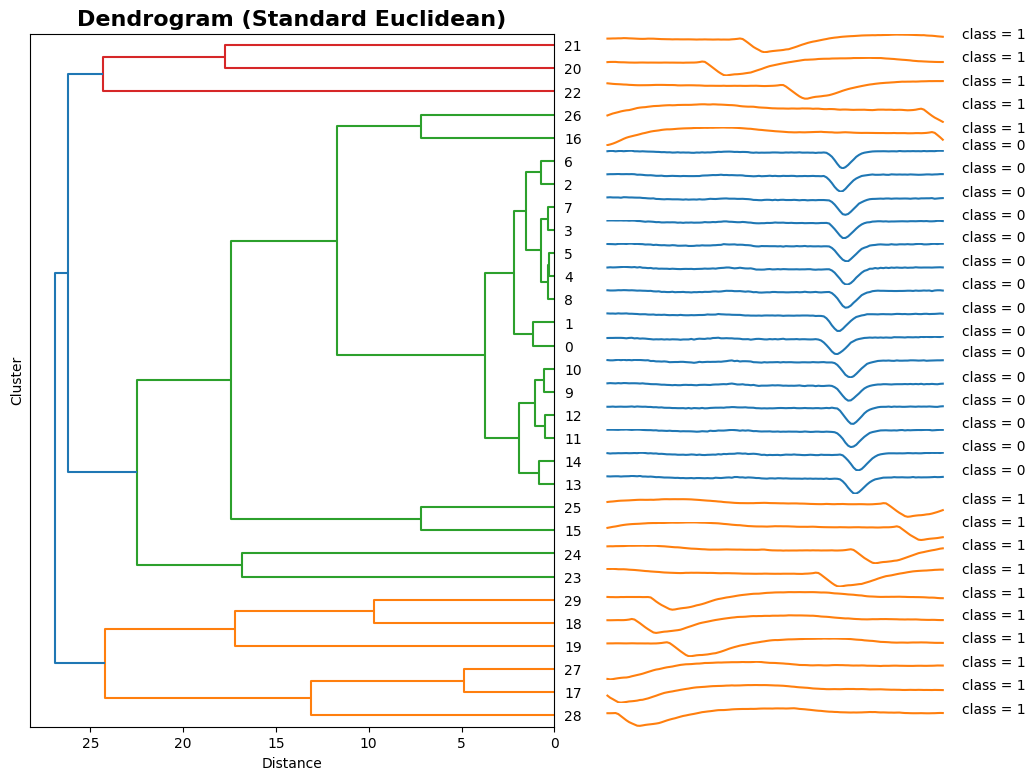


--- 2. Кластеризация: Нормализованная Евклидова метрика ---


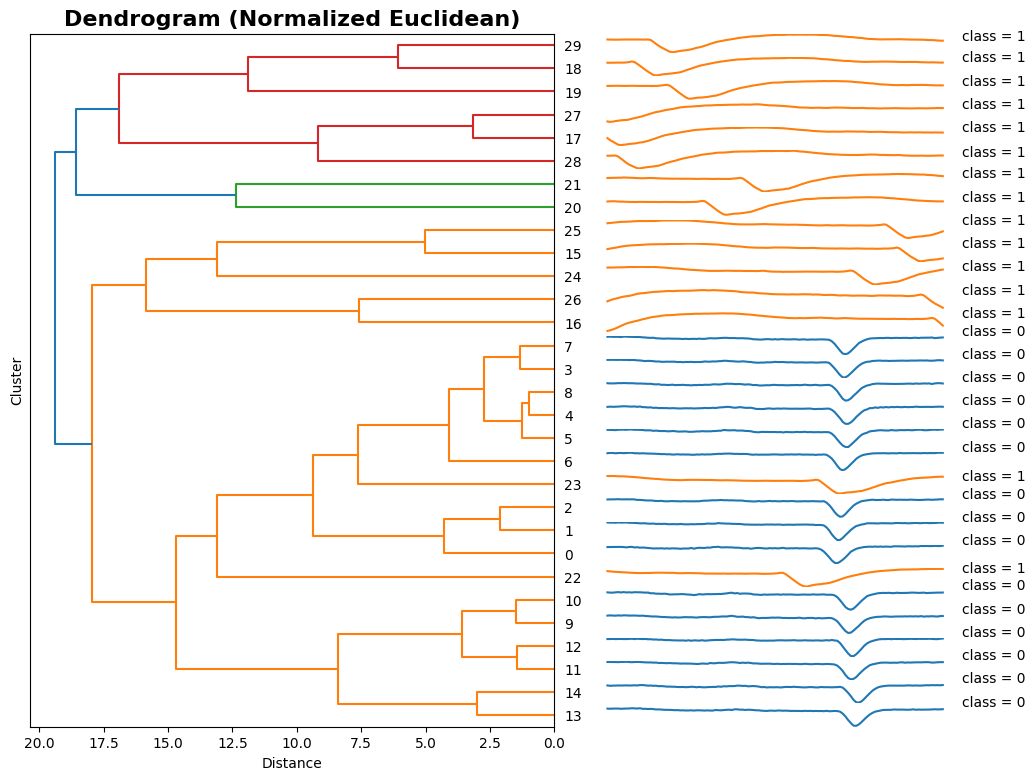

Silhouette Score (Without Normalization): 0.4183
Silhouette Score (With Normalization):    0.3275


In [16]:
# --- Эксперимент 1: Обычная Евклидова метрика (Raw Data) ---
print("--- 1. Кластеризация: Евклидова метрика (Без нормализации) ---")

# is_normalize=False -> считает обычное евклидово расстояние по сырым данным
pdist_raw = PairwiseDistance(metric='euclidean', is_normalize=False)
dist_matrix_raw = pdist_raw.calculate(subs_set)

hc_raw = TimeSeriesHierarchicalClustering(n_clusters=2, method='complete')
hc_raw.fit(dist_matrix_raw)

# Отрисовка
hc_raw.plot_dendrogram(pd.DataFrame(subs_set).T, labels, title='Dendrogram (Standard Euclidean)')
plt.show()

# Силуэтный коэффициент
sil_raw = silhouette_score(dist_matrix_raw, hc_raw.labels_, metric='precomputed')


# --- Эксперимент 2: Нормализованная Евклидова метрика ---
print("\n--- 2. Кластеризация: Нормализованная Евклидова метрика ---")

# is_normalize=True -> класс сам выберет norm_ED_distance
pdist_norm = PairwiseDistance(metric='euclidean', is_normalize=True)
dist_matrix_norm = pdist_norm.calculate(subs_set)

hc_norm = TimeSeriesHierarchicalClustering(n_clusters=2, method='complete')
hc_norm.fit(dist_matrix_norm)

# Отрисовка
hc_norm.plot_dendrogram(pd.DataFrame(subs_set).T, labels, title='Dendrogram (Normalized Euclidean)')
plt.show()

# Силуэтный коэффициент
sil_norm = silhouette_score(dist_matrix_norm, hc_norm.labels_, metric='precomputed')


# --- Вывод результатов ---
print("="*50)
print(f"Silhouette Score (Without Normalization): {sil_raw:.4f}")
print(f"Silhouette Score (With Normalization):    {sil_norm:.4f}")
print("="*50)

Вычислите силуэтные коэффициенты для оценки качества кластеризации с нормализацией и без нее, как это было сделано в задаче 4 части 1.

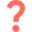
Сравните полученные результаты кластеризации с помощью построенных дендрограмм и вычисленных силуэтных коэффициентов. Позволила ли $z$-нормализации временных рядов повысить качество кластеризации?

Несмотря на то, что численное значение силуэтного коэффициента снизилось (0.418 -> 0.327), z-нормализация всё равно повысила смысловое качество кластеризации, что подтверждается структурой дендрограмм.

Почему коэффициент выше без нормализации?
В исходных данных класс 0 представляет собой почти прямые линии около нуля. Евклидово расстояние между плоскими линиями очень маленькое. С математической точки зрения это создает идеальный, сверхплотный кластер. Силуэтный коэффициент "любит" такие плотные сгустки и дает высокую оценку. Однако, второй класс при этом просто разбросан далеко от первого из-за смещения по амплитуде. Это кластеризация по принципу "уровень сигнала", а не "форма сигнала".

Почему нормализация лучше, несмотря на низкий коэффициент?
После z-нормализации ряды приводятся к одному масштабу. "Легкое" различие по амплитуде исчезает. Теперь алгоритм вынужден искать различия в сложной форме сигналов. Задача становится сложнее, дисперсия внутри кластеров может возрастать, что математически снижает силуэтный коэффициент.

Однако, судя по дендрограмме, именно нормализация позволила собрать все ряды одного типа в одну ветку, а другого — в другую. Это означает, что для решения реальной задачи нормализация сработала верно, устранив влияние случайного дрейфа изолинии.

Вывод:
Z-нормализация необходима. Она позволила сгруппировать ряды по их структурной схожести (форме), а не по случайному смещению относительно оси Y, даже если формальная метрика плотности кластеров при этом немного просела.

## **Часть 3.** Классификация изображений, представленных в виде временных рядов.

### **Задача 7.**
В данном задании вам предстоит выполнить преобразование изображения, на котором находится некоторый объект, во временной ряд. Для этого вы реализуете один из существующих методов, предложенный в [статье Кеога и др](https://dl.acm.org/doi/10.5555/1182635.1164203).

Данный метод заключается в том, что сначала на изображении выполняется поиск контура $E = \{e_i\}_{i=1}^L$, где $e_i$ – точки контура, и центра масс объекта $O$. Затем берутся точки, расположенные на контуре объекта, следующим образом.

Рассмотрим луч $OP$ с началом в центре масс объекта $O$, направление которого совпадает с положительным направлением оси Ox (см. рисунок). Далее выполняется поворот против часовой стрелки луча $OP$ вокруг центра масс $O$ на некоторый заданный угол $α$, $1° \leqslant α \leqslant 360°$. Поворот луча будет осуществляться до тех пор, пока луч не пройдет полный оборот. Все точки $P = \{P_i\}_{i=1}^K$, $P_i \in E$, $K = \lfloor \frac{360°}{α} \rfloor$, образованные пересечением луча $OP$ с контуром $E$ во время поворота, будут являться искомыми.

На завершающем шаге метода вычисляются расстояния между центром масс объекта $O$ и найденными точками на контуре $P$. В качестве функции расстояния может быть использовано манхэттенское или евклидово расстояние. Полученные расстояния будут формировать временной ряд $T$ длины $K$:
\begin{equation}
T = \{t_i\}_{i=1}^K,\;где \; t_i = dist(O, P_i), \; P_i \in P.
\end{equation}

\
<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/image2ts.png?raw=true" width="1000"></center>

Поскольку часть 3 предполагает работу с изображениями, то вы будете использовать для реализации некоторых частей кода библиотеку компьютерного зрения *cv2*. Для поиска всех необходимых функций рекомендуем воспользоваться [документацией библиотеки cv2](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html).

Загрузите изображение *example.tif* из директории *./datasets/part3* и выполните его визуализацию с помощью соответствующих функций из библиотеки *cv2*.

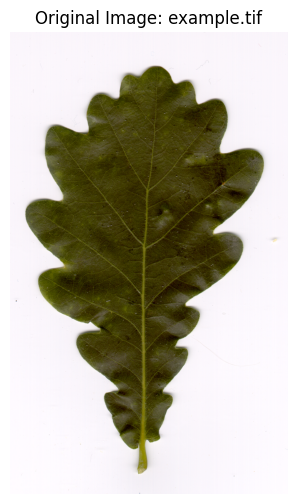

In [ ]:
img_path = './datasets/part3/example.tif'

# Загружаем изображение
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Визуализация
plt.figure(figsize=(6, 6))
plt.imshow(image_rgb)
plt.title("Original Image: example.tif")
plt.axis("off")
plt.show()

За конвертацию изображения во временной ряд с помощью описанного выше метода отвечает функция `image2ts()` из модуля *image_converter.py*. Прежде чем исходное изображение будет преобразовано во временной ряд, сначала оно должно пройти этап предварительной обработки. Предварительная обработка включает в себя следующие шаги:

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/image_preprocessing.png?raw=true" width="1000"></center>

Предобработка изображения в `image2ts()` осуществляется с помощью функции `_img_preprocess()`. Реализуйте в данной функции все представленные на диаграмме шаги предварительной обработки средствами библиотеки *cv2*. Промежуточные результаты должны совпадать с представленными на диаграмме.

Далее выполните конвертацию изображения во временной ряд, передав в функцию `image2ts()` следующие заданные вами аргументы:
*   исходное загруженное изображение;
*   шаг угла поворота;
*   параметр, определяющий нужно или нет визуализировать изображение с выделенными на нем контуром, центром масс и лучами, проведенными из центра.

Визуализируйте полученный временной ряд.


In [ ]:
def image2ts(img, angle_step, visualize):
    converter = Image2TimeSeries(angle_step=angle_step)
    return converter.convert(img, is_visualize=visualize)

angle_step = 20
visualize = True 

# --- Выполнение ---
ts = image2ts(image, angle_step, visualize)

ts_dataset = np.array([ts])

plot_ts(ts_dataset, "Time series representation of image")

### **Задача 8.**

Выполните классификацию изображений, представленных в виде временных рядов, с помощью метода $k$ ближайших соседей (kNN).

**Метод $k$ ближайших соседей (kNN)** – алгоритм классификации, заключающийся в вычислении сходства между объектами на основе некоторой заданной метрики/меры схожести. Классифицируемый объект относится к тому классу, к которому принадлежит большинство из его $k$ соседей ($k$ ближайших к нему объектов из обучающей выборки).

Для классификации на основе алгоритма kNN необходимо выполнить следующие шаги:

1. Загрузить обучающую и тестовую выборки.

2. Задать параметр алгоритма $k$, где $k$ – количество ближайших соседей, $k \in \mathbb N^*$.

3. Для каждого объекта из тестовой выборки выполнить следующее:

    3.1. Вычислить расстояние до всех объектов из обучающей выборки на основе заданной метрики/меры схожести.
    
    3.2. Отсортировать в порядке возрастания найденные расстояния.

    3.3. Найти $k$ ближайших соседей, взяв первые $k$ минимальные расстояния из отсортированного массива расстояний.

    3.4. Назначить объекту из тестовой выборки наиболее часто встречающийся класс найденных ранее ближайших соседей.


Для этого задания вам предлагается набор данных, который содержит изображения листьев четырех различных пород деревьев: дуб, ольха, ива и липа. Набор данных состоит из обучающей и тестовой выборок, включающих по 15 и 10 изображений листьев на класс соответственно. Для составления этого набора данных изображения были взяты из [Swedish Leaf Dataset](https://www.cvl.isy.liu.se/en/research/datasets/swedish-leaf/).

Загрузите изображения из обучающей и тестовой выборок, а также их метки, используя `read_images()` и `read_ts()` соответственно.
Выполните визуализацию прецедентов выборки с помощью функции `plot_images()`.


In [5]:
def read_images(dir: str) -> list[np.ndarray]:
    """
    Load all images from a directory

    Parameters
    ----------
    dir: directory path

    Returns
    -------
    images: images from a directory
    """

    images = []
    for img_path in sorted(glob.glob(dir)):
        cv_img = cv2.imread(img_path)
        images.append(cv_img)

    return images

In [6]:
def plot_images(images: list[np.ndarray], labels: np.ndarray, class_names: list[str]) -> None:
    """
    Plot some images from dataset

    Parameters
    ----------
    images: dataset of images
    labels: labels of images
    class_names: class names of images
    """

    rows = 2
    columns = 4

    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*2, rows*3))

    for num in range(1, rows*columns+1):
        fig.add_subplot(rows, columns, num)
        idx = num - 1
        plt.imshow(images[idx], aspect='auto')
        plt.title(f'{class_names[labels[idx]]}', fontsize=10)

    fig.tight_layout()

    for idx, ax in enumerate(axes.flat):
        ax.set_xticks([])
        ax.set_yticks([])

In [7]:
train_set_path = "./datasets/part3/train_set_leaves/*.tif"
test_set_path = "./datasets/part3/test_set_leaves/*.tif"

train_images = read_images(train_set_path)
test_images = read_images(test_set_path)

train_label_path = './datasets/part3/train_set_leaves/train_label.csv'
test_label_path = './datasets/part3/test_set_leaves/test_label.csv'

train_labels = read_ts(train_label_path)
train_labels = train_labels.reshape(-1).astype('int32')

test_labels = read_ts(test_label_path)
test_labels = test_labels.reshape(-1).astype('int32')

D:\code\times\2025-Grigorev-TimeSeriesCourse\practice\01 Basics\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

D:\code\times\2025-Grigorev-TimeSeriesCourse\practice\01 Basics\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



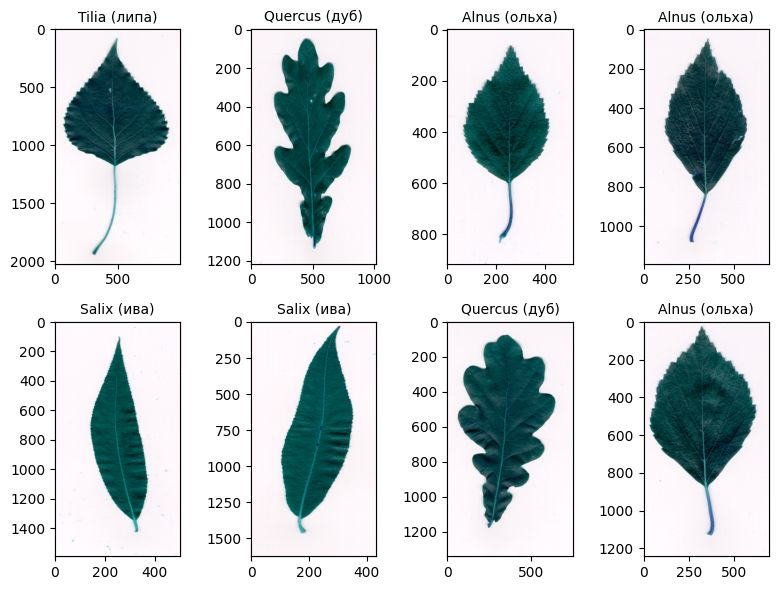

In [8]:
class_names = ['Quercus (дуб)', 'Alnus (ольха)', 'Salix (ива)', 'Tilia (липа)']
plot_images(train_images, train_labels, class_names)

Выполните преобразование изображений обучающей и тестовой выборок во временные ряды с помощью функции `image2ts()`.  

In [ ]:
angle_step = 5   # Шаг угла (чем меньше, тем точнее ряд, но дольше вычисления)
visualize = False

# --- 1. Преобразование обучающей выборки ---
train_ts = []
print("Конвертация обучающей выборки...")
for img in train_images:
    ts = image2ts(img, angle_step, visualize)
    train_ts.append(ts)

# Преобразуем список массивов в одну numpy-матрицу
train_ts = np.array(train_ts)
print(f"Обучающая выборка готова. Размерность: {train_ts.shape}")

# --- 2. Преобразование тестовой выборки ---
test_ts = []
print("Конвертация тестовой выборки...")
for img in test_images:
    ts = image2ts(img, angle_step, visualize)
    test_ts.append(ts)

test_ts = np.array(test_ts)
print(f"Тестовая выборка готова. Размерность: {test_ts.shape}")

Конвертация обучающей выборки...
Обучающая выборка готова. Размерность: (60, 72)
Конвертация тестовой выборки...
Тестовая выборка готова. Размерность: (40, 72)


Для классификации временных рядов методом $k$ ближайших соседей вам необходимо использовать класс `TimeSeriesKNN` из модуля *classification.py*.
Реализуйте метод `fit()` в классе `TimeSeriesKNN`, который выполняет поиск для каждого элемента из тестовой выборки $k$ ближайших соседей и назначает им тот класс, который является часто встречающимся среди классов ближайших соседей. В качестве параметров в метод `fit()` передается тестовая выборка. Вычислите точность классификации по метрике accuracy с помощью функции `calculate_accurary()` из модуля *classification.py*.

In [ ]:
n_neighbors = 6
metric = 'euclidean'
metric_params = {'normalize': True}

# Создаем модель
knn_euc = TimeSeriesKNN(
    n_neighbors=n_neighbors,
    metric='euclidean',
    metric_params={'normalize': True}
)

# Обучаем
knn_euc.fit(train_ts, train_labels)

# Предсказываем
print("Классификация (Euclidean)...")
preds_euc = knn_euc.predict(test_ts)

# Считаем точность
acc_euc = calculate_accuracy(test_labels, preds_euc)
print(f"Accuracy (Euclidean): {acc_euc:.4f}")

Классификация (Euclidean)...
Accuracy (Euclidean): 0.7000


In [11]:
metric = 'dtw'
metric_params = {'normalize': True}

# Создаем модель
knn_dtw = TimeSeriesKNN(
    n_neighbors=n_neighbors,
    metric='dtw',
    metric_params={'normalize': True}
)

# Обучаем
knn_dtw.fit(train_ts, train_labels)

# Предсказываем
print("Классификация (DTW)... Ждите...")
preds_dtw = knn_dtw.predict(test_ts)

# Считаем точность
acc_dtw = calculate_accuracy(test_labels, preds_dtw)
print(f"Accuracy (DTW): {acc_dtw:.4f}")

Классификация (DTW)... Ждите...
Accuracy (DTW): 0.6500


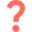
Проанализируйте результаты и сделайте выводы.

В данном эксперименте Евклидова метрика показала лучший результат, чем DTW. Это могло произойти по нескольким причинам:

Предварительное выравнивание: Метод извлечения временного ряда фактически выполняет жесткое выравнивание всех рядов относительно центра масс. Если листья на исходных фото были ориентированы примерно одинаково (черенком вниз/вверх), то пики на графиках уже синхронизированы. В ситуации, когда сдвига фазы нет, Евклидова метрика работает точнее и стабильнее, так как не пытается найти сложные нелинейные соответствия там, где они не нужны.

Параметры DTW: Мы использовали параметр окна искривления r=0.05. Это очень узкое окно, которое ограничивает возможности DTW по поиску оптимального пути. Возможно, для данной задачи требовалось более широкое окно, либо наоборот — алгоритм начал сопоставлять шум неправильным образом, что снизило точность.

Малый размер выборки: Тестовая выборка очень мала. Разница в 0.05 может означать ошибку всего на 1-2 изображениях, что находится в пределах статистической погрешности.

Итог: Несмотря на теоретическое превосходство DTW для временных рядов, для данной конкретной выборки и метода предобработки более простая нормализованная Евклидова метрика оказалась эффективнее.